In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

In [49]:
start = '2015-01-01'

In [50]:
overall = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [51]:
overall

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [52]:
stocks = overall.Symbol

In [53]:
stocks.head(5)

0     MMM
1     AOS
2     ABT
3    ABBV
4     ACN
Name: Symbol, dtype: object

In [54]:
stocks = stocks.to_list()

In [8]:
overall = overall[overall['Date added'] >= start]
#only those are relevant after the starting date of the analysis

In [9]:
removed = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1][['Date','Removed']]

In [10]:
removed

Date Removed                          
                  Date  Ticker                  Security
0          May 4, 2023     FRC       First Republic Bank
1       March 20, 2023    LUMN        Lumen Technologies
2       March 15, 2023    SBNY            Signature Bank
3       March 15, 2023    SIVB       SVB Financial Group
4      January 5, 2023     VNO      Vornado Realty Trust
..                 ...     ...                       ...
319       June 9, 1999     HPH  Harnischfeger Industries
320  December 11, 1998     LDW                     Amoco
321  December 11, 1998     GRN                General Re
322  December 11, 1998     SUN                SunAmerica
323      June 17, 1997     USL                    USLife

[324 rows x 3 columns]

In [11]:
removed = removed.set_index(removed.Date.Date)

In [12]:
removed.index = pd.to_datetime(removed.index)

In [13]:
removed = removed[removed.index >= start]

In [14]:
removed = removed.Removed.dropna()

In [15]:
removed

,Ticker,Security
Date,,
2023-05-04,FRC,First Republic Bank
2023-03-20,LUMN,Lumen Technologies
2023-03-15,SBNY,Signature Bank
2023-03-15,SIVB,SVB Financial Group
2023-01-05,VNO,Vornado Realty Trust
...,...,...
2015-03-23,AVP,Avon Products
2015-03-18,CFN,Carefusion
2015-03-12,PETM,PetSmart


In [16]:
stocks.extend(removed.Ticker.to_list())
# include already removed symbols in our analysis

In [55]:
df = yf.download(stocks,start=start)['Close']

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [56]:
df.index = pd.to_datetime(df.index)

In [19]:
removed[removed.Ticker == 'SBNY'].index[0]

Timestamp('2023-03-15 00:00:00')

In [20]:
df['SBNY'] #currently we still have prices until the last day

Date
2015-01-02    125.250000
2015-01-05    121.809998
2015-01-06    120.360001
2015-01-07    120.970001
2015-01-08    124.080002
                 ...    
2023-05-15      0.118000
2023-05-16      0.122000
2023-05-17      0.137000
2023-05-18      0.146000
2023-05-19      0.139900
Name: SBNY, Length: 2110, dtype: float64

In [21]:
df['SBNY'].index <= removed[removed.Ticker == 'SBNY'].index[0]
#filter for dates before the removal date

array([ True,  True,  True, ..., False, False, False])

In [22]:
df['SBNY'] = df['SBNY'][df['SBNY'].index <= removed[removed.Ticker == 'SBNY'].index[0]]

In [23]:
df['SBNY'] # now no prices after that date

Date
2015-01-02    125.250000
2015-01-05    121.809998
2015-01-06    120.360001
2015-01-07    120.970001
2015-01-08    124.080002
                 ...    
2023-05-15           NaN
2023-05-16           NaN
2023-05-17           NaN
2023-05-18           NaN
2023-05-19           NaN
Name: SBNY, Length: 2110, dtype: float64

In [24]:
def pricefilter_rem(ticker):
    df[ticker] = df[ticker][df[ticker].index <= removed[removed.Ticker == ticker].index[0]]

In [25]:
def pricefilter_add(ticker):
    df[ticker] = df[ticker][df[ticker].index >= 
                            overall[overall.Symbol == ticker]['Date added'].values[0]]

In [26]:
for ticker_rem in removed.Ticker:
    pricefilter_rem(ticker_rem)
for ticker_add in overall.Symbol:
    pricefilter_add(ticker_add)

In [27]:
# until here we went last time
# we filtered our price dataframe (df) for removed and added stocks

In [57]:
ret_df = df.pct_change()

In [58]:
ret_df

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.018738,-0.000556,-0.013181,-0.028172,-0.018819,-0.008512,0.000223,-0.005984,-0.016884,-0.004976,...,-0.017020,-0.011351,-0.027362,-0.006932,-0.062237,-0.020318,0.037304,-0.014077,-0.037469,-0.006003
2015-01-06,-0.015578,-0.015590,-0.000703,0.000094,-0.004950,0.005463,-0.011356,0.002236,-0.007213,-0.020145,...,-0.021331,0.005321,-0.005316,-0.012410,-0.005881,-0.012274,-0.008477,-0.007205,-0.038193,-0.009756
2015-01-07,0.013272,-0.000566,0.021489,0.014022,0.040417,0.019960,0.008108,0.005835,0.020990,0.008223,...,0.029368,0.008635,0.010133,0.025918,0.007887,0.033138,0.024870,0.025465,0.009546,0.020643
2015-01-08,0.029975,0.012262,0.008765,0.038422,0.010459,0.002283,0.020554,0.017403,0.015249,0.025453,...,0.012031,0.011599,0.016645,0.024689,0.007546,0.017420,0.010617,0.021359,0.013994,0.015399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,0.003922,0.018545,-0.007407,-0.002897,-0.003806,0.013743,-0.005883,-0.023407,0.001154,0.030467,...,0.003036,-0.014226,-0.006712,0.001468,-0.001050,-0.005270,0.000512,0.017057,0.084708,0.001253
2023-05-16,-0.013282,-0.005602,-0.037802,0.000000,-0.022512,0.007269,-0.004097,-0.007723,0.006054,-0.001620,...,-0.025163,-0.019438,-0.024270,-0.012702,-0.013188,0.007258,-0.014472,-0.015959,-0.023428,-0.013054
2023-05-17,0.011719,0.050000,0.040566,0.003603,0.000419,0.001088,-0.005211,-0.019860,0.019485,0.033381,...,0.056963,-0.008259,0.022435,-0.006927,0.006682,-0.011241,-0.003782,0.019859,0.101431,-0.013833


In [59]:
mtl_ret = (ret_df + 1).resample('M').prod()

In [60]:
mtl_ret

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,0.931213,0.910406,1.002775,1.071618,0.915920,1.050741,0.996882,0.991110,0.945858,0.969450,...,1.007216,1.039037,0.941721,0.963412,0.895483,0.999032,0.995648,1.077877,0.846942,0.986608
2015-02-28,1.117554,0.975958,0.974402,1.096449,1.002486,1.081115,1.058311,1.020528,1.071403,1.127905,...,0.963163,0.940048,1.012812,1.059564,1.046921,1.122164,1.073952,1.090942,1.116027,1.078633
2015-03-31,0.984364,1.101879,0.966178,0.968628,0.967603,1.106170,0.978045,1.041244,1.040653,0.934766,...,0.883368,0.986678,0.960018,0.960008,0.980952,0.970534,0.976161,0.996376,1.009723,1.004339
2015-04-30,0.995668,0.914930,0.955308,1.005786,1.104544,1.005542,1.001943,0.985065,0.988900,1.028672,...,0.882348,0.974145,1.027882,1.002162,1.057110,1.091972,0.934649,1.014991,1.049630,0.959602
2015-05-31,0.995649,0.877407,1.071469,1.040991,1.029848,0.984777,1.046963,1.052900,1.036589,1.039837,...,0.906545,1.004129,0.975163,1.020392,0.987844,1.048278,1.038693,1.190704,1.019054,1.120441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,1.016238,1.268868,1.035707,1.110521,0.914238,1.019613,1.006922,1.025008,1.045758,1.100467,...,1.256699,0.980887,1.051768,1.156721,0.940671,1.018972,0.998745,1.233103,1.081367,1.129239
2023-02-28,0.933522,0.990087,0.951931,1.021623,1.041624,0.920691,0.920127,1.087801,0.951622,0.874737,...,1.045639,0.938927,0.947418,1.033668,0.986924,0.974332,0.972750,0.949617,0.952220,1.009124
2023-03-31,0.974431,0.923029,0.838921,1.118649,1.035543,1.029249,0.995478,0.969571,1.076295,1.189597,...,1.032666,1.044448,0.997725,1.031784,1.019971,1.038691,1.043029,1.059117,0.591268,0.996647


In [61]:
mtl_12 = mtl_ret.rolling(12).apply(np.prod).dropna()

In [62]:
mtl_12

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,1.030819,0.785569,0.949231,0.962773,0.899074,1.146474,1.000223,1.192511,1.176272,1.298590,...,0.471033,0.994186,0.839707,1.171770,0.958508,1.009675,0.911182,0.899522,0.965005,1.106442
2016-01-31,0.996823,0.794417,0.956289,0.830830,0.909694,0.942241,0.845621,1.165258,1.255980,1.270925,...,0.455154,1.018385,0.890528,1.177094,1.054252,1.001245,0.885459,0.723700,0.946578,1.007489
2016-02-29,0.884861,0.855950,0.958110,0.752686,0.902645,0.842935,0.817817,1.148411,1.113629,1.076486,...,0.578807,1.120748,0.905241,1.149972,1.047899,0.893478,0.804137,0.678528,0.797307,0.890866
2016-03-31,0.959085,0.776999,1.071147,0.875914,0.975743,0.761415,0.902871,1.154221,1.231722,1.268596,...,0.742215,1.201379,0.983412,1.211043,1.167904,1.039761,0.907335,0.760582,0.896667,0.957658
2016-04-30,0.989123,0.718368,1.091608,0.749021,0.943396,0.744532,0.838001,1.161668,1.218780,1.238759,...,0.794994,1.180478,1.011789,1.168627,1.128579,0.925547,1.053988,0.679409,0.971066,1.058757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,1.091588,0.979964,0.657769,0.825552,1.079334,1.240529,0.867331,1.389249,0.789213,0.693131,...,1.212873,0.987224,1.527251,0.689442,0.990383,1.042662,1.066170,0.621032,0.783840,0.828320
2023-02-28,1.089061,0.926377,0.708920,0.892745,1.041483,1.091419,0.843310,1.485884,0.840295,0.692675,...,1.252543,0.959008,1.401556,0.703177,1.154019,1.037363,1.003114,0.726400,0.714064,0.862381
2023-03-31,1.045417,0.808219,0.587601,0.944390,0.983098,1.034904,0.855526,1.401694,0.847522,0.845814,...,1.403436,0.934460,1.327764,0.798050,1.228008,1.114317,1.010164,0.768673,0.456528,0.882549


In [34]:
top_ = mtl_12.loc['2015-12-31'].nlargest(5)

In [35]:
top_

ABMD    2.419726
NFLX    2.294549
AMZN    2.190749
AYI     1.671433
NVDA    1.637357
Name: 2015-12-31 00:00:00, dtype: float64

In [36]:
top_.name

Timestamp('2015-12-31 00:00:00', freq='M')

In [37]:
mtl_ret[top_.name:][1:2]

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-31,0.900502,0.738602,0.920661,1.010232,0.924758,0.926739,0.863562,0.945171,0.842797,1.0,...,0.998717,0.96779,0.917215,0.984932,1.0,0.990691,0.967541,1.0,0.830769,0.898372


In [38]:
relevant_ret = mtl_ret[top_.name:][1:2][top_.index]

In [39]:
relevant_ret

,ABMD,NFLX,AMZN,AYI,NVDA
Date,,,,,
2016-01-31,0.945171,0.802938,0.868485,0.865825,0.888653


In [40]:
relevant_ret.mean(axis=1)

Date
2016-01-31    0.874214
Freq: M, dtype: float64

In [63]:
def top_performers(date):
    all_ = mtl_12.loc[date]
    top = all_.nlargest(5)
    relevant_ret = mtl_ret[top.name:][1:2][top.index]
    return (relevant_ret).mean(axis=1).values[0]

In [64]:
top_performers('2015-12-31')

0.892359377588893

In [65]:
returns = []
for date in mtl_12.index[:-1]:
    returns.append(top_performers(date))

In [66]:
pd.Series(returns).prod()

18.13834315066566

<AxesSubplot:xlabel='Date'>

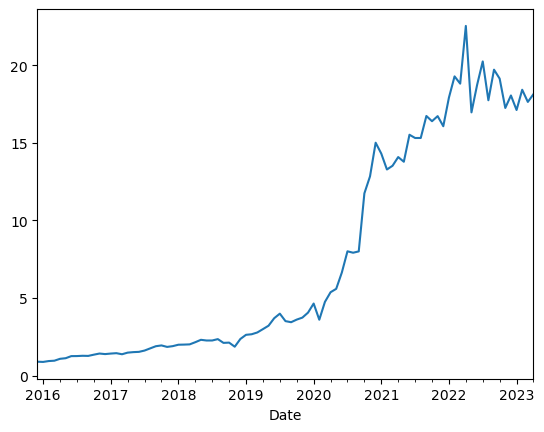

In [67]:
pd.Series(returns, index=mtl_12.index[:-1]).cumprod().plot()

In [46]:
s_p500 = yf.download('^GSPC',start=start).Close

[*********************100%***********************]  1 of 1 completed


In [47]:
s_p500

Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
2015-01-07    2025.900024
2015-01-08    2062.139893
                 ...     
2023-05-15    4136.279785
2023-05-16    4109.899902
2023-05-17    4158.770020
2023-05-18    4198.049805
2023-05-19    4191.979980
Name: Close, Length: 2110, dtype: float64

In [48]:
 4191.979980/2058.199951

2.0367214458261347